<a href="https://colab.research.google.com/github/brahma2024/LLM-study/blob/main/3_Activations%26Gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actiavtions & Gradients, BatchNorm

# What we learn in this exercise

- **Older Techniques** such as
1. Network Parameter Initialization

- **Modern techniques**
1. Residual Network connections
2. Use of Normalization layers e.g. Batch normalizaton, Layer Normalization, group Normalization
  - Batch Normalization paper: https://arxiv.org/pdf/1502.03167
  - Batch normalization comes at a cost:
    - without normalizing the batch the batch samples had some pre-activations, and activations and logits which were detrministic
    - with batch norm: they are coupled together and since the batch is randomly sampled
    - so hidden state activations hpreact and its logits for one example is not just a function of that single example, but the function of other examples in the batch
    - it does add some jitter in h
    - this though in a way is good from the point of view of regularization
  - But couple examples together in batch norm is not really required
    - e.g. of issues due to coupling can come from error introduced by other samples/examples in the batch
  - *Layer Norm, Instance Norm, Group Norm*: Alternate norm techniques are prefered
3. Better optimizers, not just stochastic gradient descent but slightly more complex optimizers e.g. Adam, RMSprop





In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt

--2024-06-04 20:21:54--  https://raw.githubusercontent.com/brahma2024/LLM-study/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228146 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.008s  

2024-06-04 20:21:54 (28.9 MB/s) - ‘names.txt’ saved [228146/228146]



In [3]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], [] # input, output lists

  for w in words:
    context = [0] * block_size # initializing ...
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context),'--> ', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


# spliting dataset: training, dev/validation, test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(n1, n2)
Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xtest, Ytest = build_dataset(words[n2:])  # 10%

25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(21474836487)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size)**0.5)) # 0.2 # kaiming normalization
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # 0.01 instead of 0.0 to keep a little bit of entropy, but generall to keep hpreact distribution within a unit gaussian range around 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # at initialization we want logits to be very diffused and small
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # at initialization we want logits to be very very small, roughly 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden)) # updated during optimization, used during inference
bnstd_running = torch.ones((1, n_hidden))   # updated during optimization, used during inference

epsilon = 1e-05 # in case bnstd = 0
# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [13]:
# same optimization from MLP.ipymb
max_steps = 200000
# batch_size = 32
batch_size = int(1/100 * len(words)) # batch_size for training is proportionate to the training data for faster convergence and less jitter
# print(f'{batch_size = }')
lossi = []      # capture loss at each step for plotting

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y


  # forward pass
  emb = C[Xb] # indexing in to embedding matrix C
  # embcat = emb.view(-1, n_embd * block_size)
  embcat = emb.view(emb.shape[0], -1)
  # Linear Layer
  # -----------
  hpreact = embcat @ W1 #+ b1 # this bias is wasteful in the presence of batch gain + bias # hidden layer pre-activation

  # BatchNorm layer
  # ---------------
  # BatchNorm Layer: is used to control the statistics of activations in NeuralNet
  # also keeping a running account of the mean/std
  mini_batch_meani = hpreact.mean(0, keepdim=True) # calculates the mean over all the elements i.e. over each neuron mini_batch_mean.shape = [1, n_hidden]
  mini_batch_stdDevi = hpreact.std(0, keepdim=True) + epsilon


  # now we dont want the batch normalization to force the pre-activation layer to be unit gaussian always
  # it would be beneficial if the distrbution is allowed to move around
  # allow the layer to be more diffused or sharp or allow some neurons to be more/less trigger happy
  # so we should allow the | scale and shift |

  hpreact = bngain * ((hpreact - mini_batch_meani)/ (mini_batch_stdDevi)) + bnbias

  with torch.no_grad(): # gets updated in parallel of gradient base optimization
  # 0.001 is the momentum
  # for larger batch sizes we can use larger momentum because the mean/stddev would not fluctuate much | e.g. for batch_size > 1% of vocab, momentum ~ 0.1
  # momentum for smaller batch sizes e.g. 32 used here can vary/fluctuate a lot and hence we use a much smaller momentum value of 0.001
    bnmean_running = 0.999 * bnmean_running + 0.001 * mini_batch_meani # small update in the direction of the current batch mean
    bnstd_running = 0.999 * bnstd_running + 0.001 * mini_batch_stdDevi # small update in the direction of the current batch std
  # --------------

  # Non-Linearity | Activation
  # --------------------------
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2  # output layer
  # print(f'{embcat.shape = } | {hpreact.shape =} | {h.shape = } | {logits.shape = }')
  loss = F.cross_entropy(logits, Yb)  # loss function


  # backward pass
  for p in parameters:
    p.grad = None # setting p.grad = 0
  loss.backward() # applying the gradient

  # udpate
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    # print(f'{p.shape=}')
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every 10K steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f} | {loss.log10().item():2f}')
  lossi.append(loss.log10().item()) # capture the exponents of loss

  # break

      0/ 200000: 3.296651 | 0.518073
  10000/ 200000: 2.111945 | 0.324683
  20000/ 200000: 2.023906 | 0.306190
  30000/ 200000: 2.103454 | 0.322933
  40000/ 200000: 2.058092 | 0.313465
  50000/ 200000: 2.256985 | 0.353529
  60000/ 200000: 1.929620 | 0.285472
  70000/ 200000: 2.030158 | 0.307530
  80000/ 200000: 2.100512 | 0.322325
  90000/ 200000: 1.989230 | 0.298685
 100000/ 200000: 2.036936 | 0.308977
 110000/ 200000: 1.999953 | 0.301020
 120000/ 200000: 2.122985 | 0.326947
 130000/ 200000: 2.021812 | 0.305741
 140000/ 200000: 2.059544 | 0.313771
 150000/ 200000: 2.040724 | 0.309784
 160000/ 200000: 2.058624 | 0.313577
 170000/ 200000: 2.048985 | 0.311539
 180000/ 200000: 1.982540 | 0.297222
 190000/ 200000: 1.974807 | 0.295525


In [176]:
emb.shape, embcat.shape, W1.shape, hpreact.shape

(torch.Size([182580, 3, 10]),
 torch.Size([182580, 30]),
 torch.Size([30, 200]),
 torch.Size([182580, 200]))

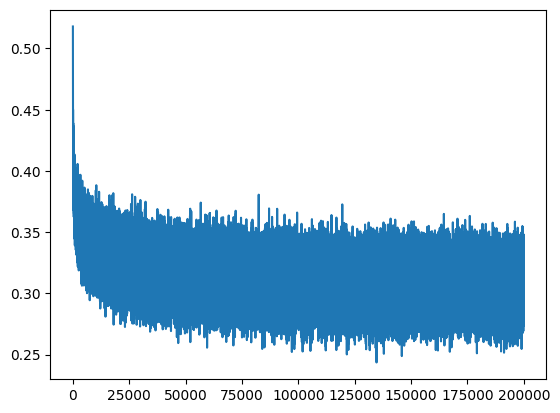

In [162]:
plt.plot(lossi) # proper initialization results in much well behaved loss

In [ ]:
# By looking at the Hockeystick plot and/or the loss values in the 1st optimization step we can see that the initialization is all messed up
# This is aparent because of the high loss at the first step

# **Network Initialization**
- By looking at the Hockeystick plot and/or the loss values in the 1st optimization step we can see that the initialization is all messed up
- This is aparent because of the high loss at the first step
- In training of neural nets, you will always have a rough idea, what loss to expect at initialization, and that just depends on the
  - loss function, and
  - the problem setup
- in our case here, basically what we would like is, that at initizalition, there are 27 characters and anyone could come next so the equal likeihood of being selected, i.e. the probability distribution should uniform distribution, assigninging equal probablity to each character = 1/27.0

In [5]:
# At initialization: whatIdeal expected probablity for each character = 1/27.0
# loss = - log likelihood of the probablities
prob = [1/27.0] * 27
exp_probsatIni = torch.tensor(prob)
loss = - exp_probsatIni.log().mean()
loss

tensor(3.2958)

# **So whats the issue at Network Initialiation**
- At initializaiton, NN is creating probablity distribution that assigns higher probablities to some characters comparied to others
- This results in a NN model which is very confidently wrong, which resuts in very high loss

In [19]:
# 4-dimensional example of the issue
# logits = torch.tensor([0.0,0.0,0.0,0.0])  # assuming 4 chracters, and the probablities assigned to them at out
logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# we notice that everytime the logits change in a random way,
# asisgning highly disproportionate/extreme probablities to each character at start, the loss increases
# if the logits (log probabilities) are more diffused, than the loss is substantially lower
# so when the network is initialized, we want the logits to be roughly 0.0

(tensor([8.8853, 4.9752, 5.7590, 9.9383]),
 tensor([0.2545, 0.0051, 0.0112, 0.7293]),
 tensor(4.4950))

# **Tanh: The squashing function**
- By initializing the W2 & b2 to a much smaller values at initialization, the loss optimization looks very well behaved
- But there is another deeper issue lurking with the *TANH function*
- tanh function is a squashing function,
  - i.e. if the variance/std deviation of hpreact is too large, the neurons with large pre-activations get saturated i.e. when they pass through tanh non-linear squashing, they form the flat tails of the tanh, where the slope is 0
  - this means, when the gradients are applied to those parameters of those neurons, they dont see a change i.e. can be quantified as dead neurons

In [163]:
# visualizing the problems with the values of the hidden state, h
# a lot of values are 1.0 or -1.0
h, h.shape

(tensor([[-0.9998,  0.3228,  0.9984,  ...,  0.9410,  0.5434, -0.7743],
         [-0.2471,  0.9801, -0.9598,  ...,  0.9877,  0.9982,  1.0000],
         [-0.4699, -0.0854,  0.9450,  ...,  0.5737, -0.6992,  0.8520],
         ...,
         [-0.9975,  0.9954,  0.9959,  ...,  0.9837,  0.7799, -0.9867],
         [ 0.2989,  0.1806,  0.9741,  ..., -0.8418, -0.8789, -0.9997],
         [-0.0822, -0.9918, -0.5715,  ..., -0.9896, -0.1769,  0.9113]],
        grad_fn=<TanhBackward0>),
 torch.Size([320, 200]))

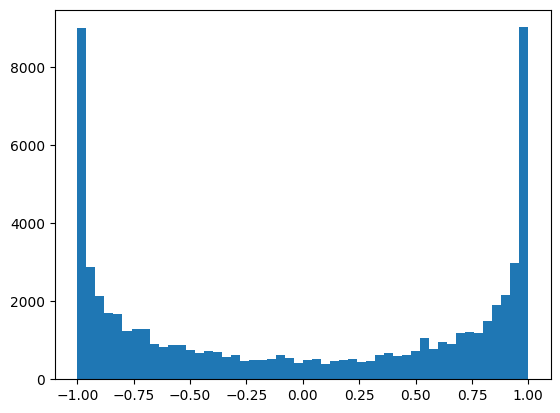

In [164]:
# plt.hist(h.detach().numpy(),50)
plt.hist(h.view(-1).tolist(), 50); # ; to supress output we dont want, and plotting histograms in 50 bins

# we will see that most of the values will take on values of -1.0 and 1.0, so the tanh function is very active

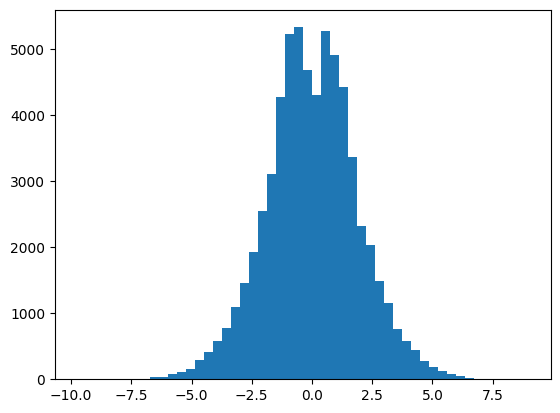

In [165]:
# why is tanh active
# lets plot the hpreact
plt.hist(hpreact.view(-1).tolist(), 50); # we see that if the distribution fo the preactivation is very very broad, then tanh gets very active and saturates the output

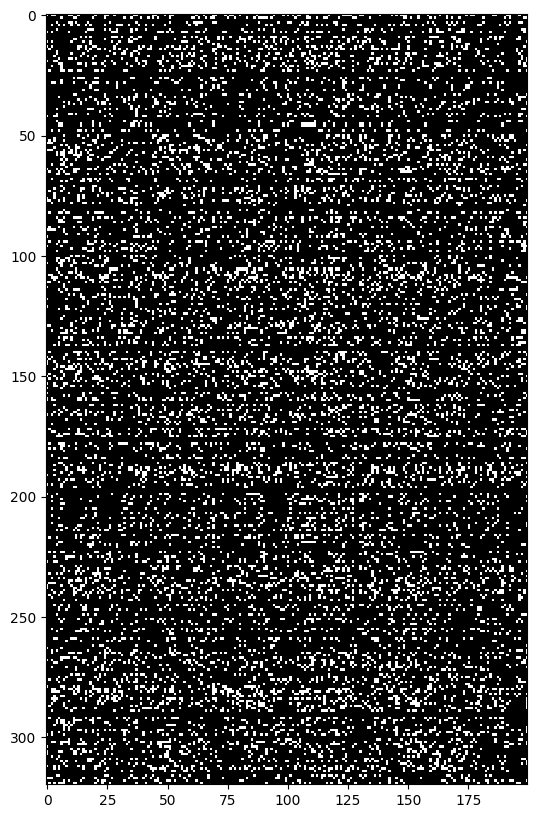

In [166]:
# To see how often values of tanh function ( values of tensor h) are in the flat region
# plotting for the 32 examples / 200 neurons
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # h.abs > 0.99 is a boolen representation

# black denotes -1.0 < h < 1.0 i.e. tanh is very active and the backward gradient is distroyed
# white denotes h = +/- 1.0
# any neuron which shows white for all 32 examples, means its not getting optimized for any of the examples/samples and can be qualified as a dead neuron

# **Problem of Dead Neurons**

- As seen in the example above, some neurons in the hidden layers can be dead or non-responsive to inputs and grdient optimization, and this can happen due the following reason
  - At initialization the weights/biases are set such that some neurons are forever dead
  - The learning rate is too high, and it kicks the neurons out of the data manifold, sort of causing that neuron to become forever dead ( i.e. in never learns/optimizes)
- And what happens, that during training the neurons are training, moving and due to a large gradient the neurons get knocked off and then they never learn

# **How to fix the issue of dead neurons**
1. hpreact is an input to tanh function
  1. by keeping hpreact closer to 0 i.e. mean = 0 with a unit std. dev. then the output of the tanh function will not be saturated
  2. Now if the NN has many hidden layers, with each of them having different parameter distributions (Weights * biases)
  3. we can either initialize smaller values to the layer parameters e.g. W1 * 0.01 and bias * 0.01, this should restrict the hpreact distribution within a measured range, around 0 with a std. dev. <= 1

In [172]:
# Another issue with batch norm is that it expects a batch so how do we feed in a single example
# The work around is
# Calibrate the batch norm at the end of the training
# ideally we use bnmean_running/bnstd_running instead of calculating the bnmean/bnstd like we are doing here

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

  # at inference we use the fixed bnmean/bnstd

In [173]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xtest, Ytest),
  }[split]

  emb = C[x] # (N = batch_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1 # (N, n_hidden)
  #hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True))/ hpreact.std(0, keepdim=True)) + bnbias
  # so instead of calculating mean/std we can use a fixed mean/std at inference
  # so we now can pass a single example and sample from our model
  # hpreact = bngain * ((hpreact - bnmean)/bnstd) + bnbias
  hpreact = bngain * ((hpreact - bnmean_running)/bnstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(f'{split = } | {loss = }')



split_loss('train')
split_loss('val')
split_loss('test')


split = 'train' | loss = tensor(2.0222)
split = 'val' | loss = tensor(2.0936)
split = 'test' | loss = tensor(2.0955)


In [ ]:
# loss log

# original: No initialization/weight sizing etc
train = 2.1229
val = 2.1592

# fix softmax confidently wrong | by scaling W2 & b2 down to keep logits (log probs) for all characters ~ same
train = 2.0711
val = 2.1323

# fix tanh layer saturation by scaling W1 & b1 down at initialization, so that the hpreact distribution has a mean ~ 0.0 and std. dev. ~ < 1 i.e. unit gaussian
train = 2.0384
val = 2.1004

# use semi-principled "kaiming init" instead of hacky init: kaiming normalization with gain = 5/3 for tanh / (sqrt of fan_in)
train = 2.0393
val = 2.1056

# we can see improvement due to initialization

# add a batch norm layer
train = 2.0690
val = 2.1117 # Very simple NN: Improvement is not expected | this is very useful for very deep NN

# if we make the batch-size ~ 0.2 * len(vocab_size) to reduce the jitter in the sample being too small and spread out
train = 2.0222
val = 2.0938

# **Method to Initialization**
- Instead of randomly selecting a value from 0.1, 0.2 or 0.001 etc for W1/W2 and b1/b2, there actually is a more structured approach
- mathematically, looking at the variance of the hp layer its been found that the best way to scale down W1 is by
  - dividing by sprt(fan_in) where fan_in = n_embd

- This is referred to as **'Kaiming Normalization'**
  - pytorch has a function torch.init.kaiming_normal -> implementing std = gain/srt(fan_mode)
  - https://pytorch.org/docs/stable/nn.init.html


**Why do we need a gain**
- Tanh (like RELU) is a contractive optimization
- to compensate for the contraction, we multiple by the gain and divide by the sqrt(fan_in) to renormalize the weights to unit std. dev.
- gain for tanh pre-activation = 5/3

**why *times* 5/3**
- The 5/3 gain in the tanh comes for the average value of tanh^2(x) where x is distributed as a Gaussian, i.e.
  - integrate (tanh x)^2*exp(-x^2/2)/sqrt(2*pi) from -inf to inf ~= 0.39

- The square root of this value is how much the tanh squeezes the variance of the incoming variable: 0.39 ** .5 ~= 0.63 ~= 3/5 (hence 5/3 is just an approximation of the exact gain).

- We then multiply by the gain to keep the output variance 1.

10**0.5 = 3.1622776601683795 | (5/3)/(10**0.5) =0.5270462766947299
tensor(0.0094) tensor(1.0008)
tensor(-0.0005) tensor(1.6805)


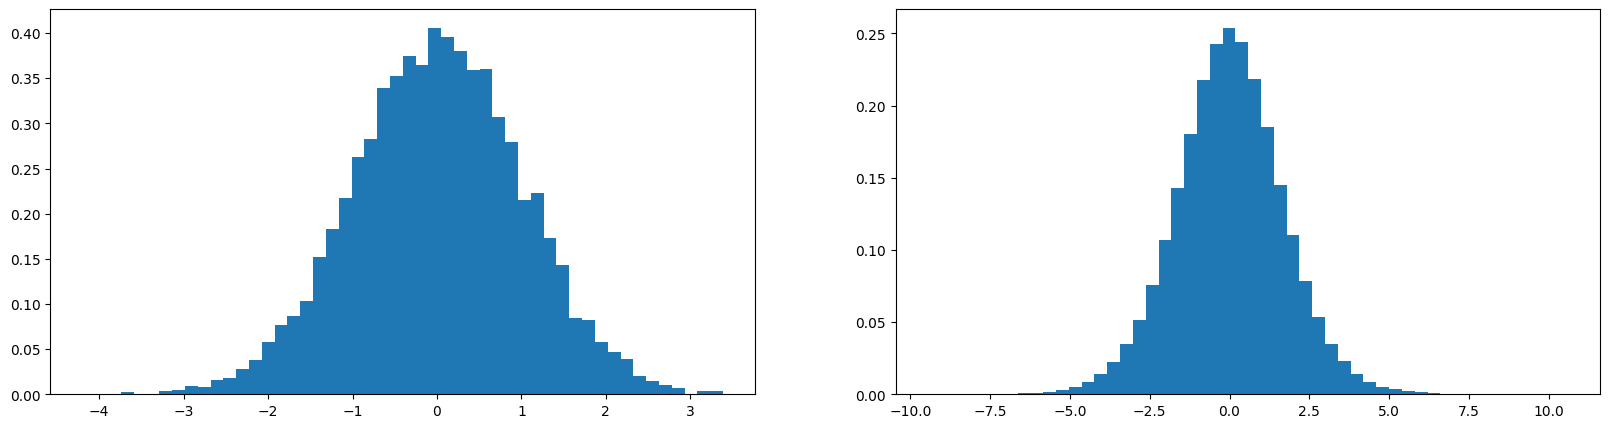

In [143]:
# lets look at an example
x = torch.randn(1000, 10) # 1000 examples with 10-dim embedding * context length (or block_size)
w = torch.randn(10, 200) * ((5/3)/ 10**0.5) # 10 weights for each of 200 neurons
hp = x @ w                # hpreach layer without any bias just a dot product of inputs and weights of the hidden layer
print(f'{10**0.5 = } | {(5/3)/(10**0.5) =}')
print(x.mean(), x.std())
print(hp.mean(), hp.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(hp.view(-1).tolist(), 50, density=True);

In [ ]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  # print(f'{context = }')
  while True:
    # forward pass the neural net
    emb = C[torch.tensor(context)]
    embcat = emb.view(1, -1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * ((hpreact - bnmean_running)/bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out.append(ix)
    # shift the context window and track the samples
    context = context[1:] + [ix]
    # if we sample the special '.' token, break
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

markelie.
ailyni.
sas.
roseelawsie.
emelyn.
johkeryon.
amaya.
hammie.
ori.
juley.
mic.
shami.
heli.
eliah.
keka.
din.
sier.
rihah.
kaos.
ramyia.


In [ ]:
# Summarizing + Pytorch-yfying our code
# -------------------------------------
# Here we are litterally building the Pytorch class

# **Refer**

*   https://pytorch.org/docs/stable/nn.html
*   https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

In [129]:
# Let's train a deeper network
# Wrapping Layers into Modules | Linear | BatchNorm1d | Tanh
# these modules are available in pytorch in torch.nn

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) /fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = self.gamma * ((x - xmean)/torch.sqrt(xvar + self.eps)) + self.beta # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    #update buffers
    with torch.no_grad(): # Torch.no_grad makes sure that Pytorch does not build out entire computational graph for running_mean/variance
      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return[self.gamma, self.beta]

class Tanh:

  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return[]


n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1 # since we are using batchnorm layer after the output layer, we will be changing the gamma i.e. gain instead of weights to make the output layer less confident
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [130]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # to maintain a list of update:data ratio

for i in range(max_steps):

  # minibatch construct
  ix= torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # maintaing the list of update:data ratio for every single iteration
  # ratio of std. dev of updates to std. dev. of data - tells us how great are the updates compared to the value of the parameters
  # log10: means we are basically looking at the exponents of the ratio
  with torch.no_grad():
      ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i > 1000:
      break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2945


# **Coding Diagnostics Tools to visualize our NN performance**

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.16%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.75%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 2.34%
layer 14 (      Tanh): mean -0.01, std 0.65, saturated: 2.28%


Text(0.5, 1.0, 'activation distribution')

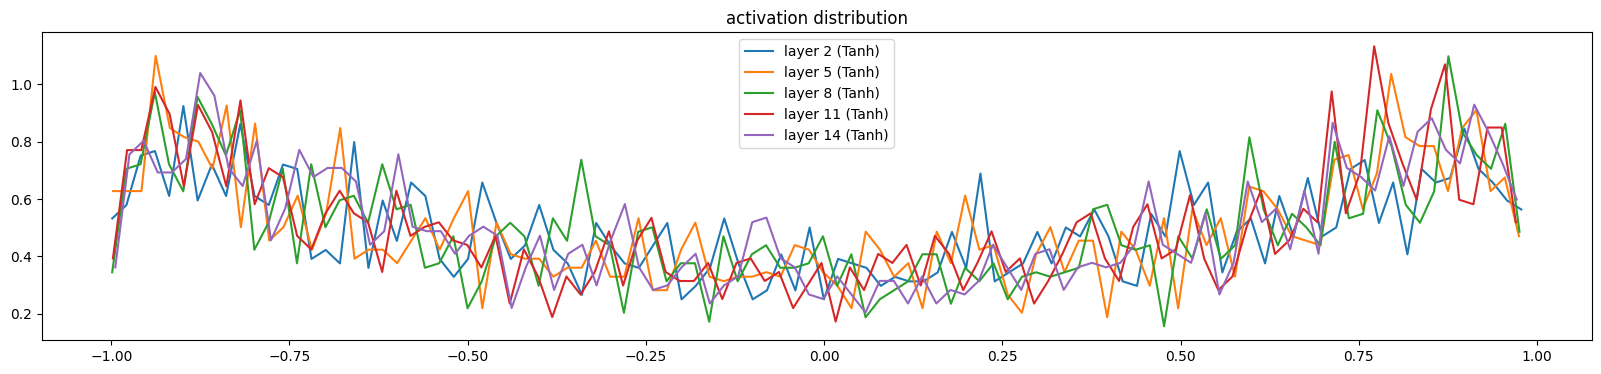

In [131]:
# visualizing histograms: Activations statistics of the forward pass esp. Tanh layer
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exlude the output layer i.e. softmax layer
  if isinstance(layer, Tanh):
    t = layer.out
    # print(f'{t.shape=}')
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

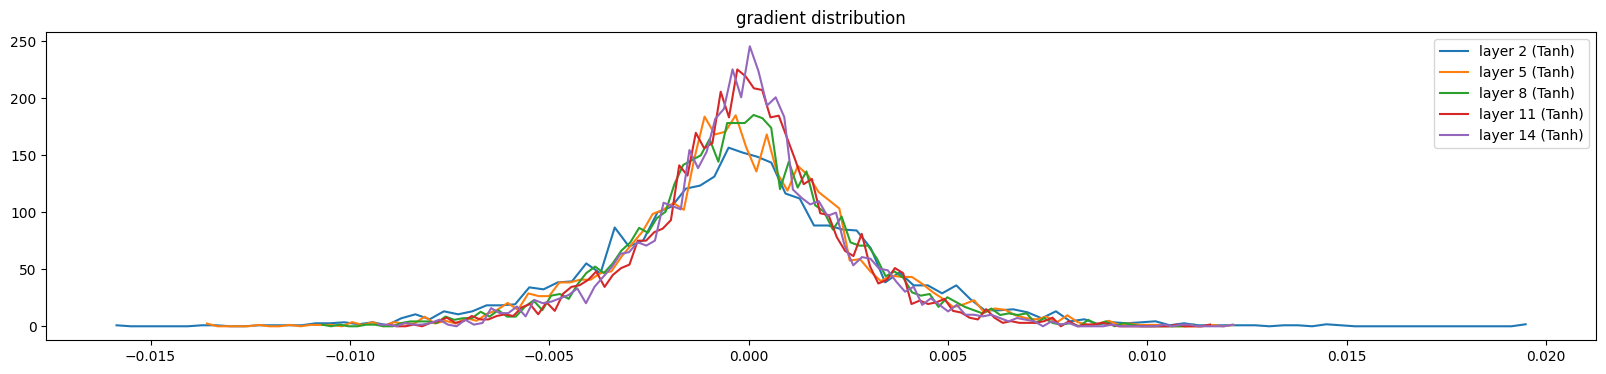

In [132]:
# visualizing histograms: Activation Statistics of the backward pass
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exlude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.653583e-03 | grad:data ratio 8.645086e-03
weight  (30, 100) | mean +0.000127 | std 7.623654e-03 | grad:data ratio 2.439867e-02
weight (100, 100) | mean -0.000050 | std 6.336628e-03 | grad:data ratio 3.793249e-02
weight (100, 100) | mean +0.000028 | std 5.340235e-03 | grad:data ratio 3.168324e-02
weight (100, 100) | mean -0.000012 | std 5.162905e-03 | grad:data ratio 3.077666e-02
weight (100, 100) | mean +0.000029 | std 5.001304e-03 | grad:data ratio 2.980161e-02
weight  (100, 27) | mean +0.000026 | std 9.882652e-03 | grad:data ratio 5.938657e-02


Text(0.5, 1.0, 'weights gradients distribution')

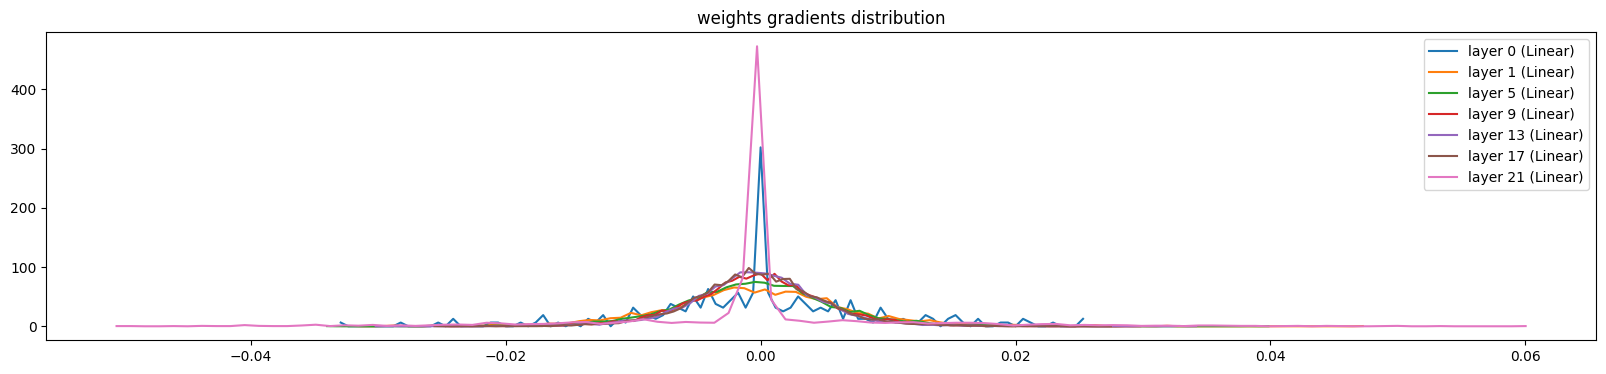

In [133]:
# visualizing histograms: Weights Gradients Distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # limiting only to the 2-dim parameters i.e. the weights | skipping 1-d parameters like biases, gamma, beta, gain, batchnorm etc
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    # t.std/p.std = helps us understand the scale of the gradient w.r.t. scale of the data
    # if grad:data ratio is too large or too small then we are in trouble and needs to find a solution
    # a good ratio is 1e-3

    # if we observe the final layer / softmax layer then we see that the grad:data is 1e-1 which is almost 10x higher than for other layers
    # this means that the final layer is learning 10x faster than other layers
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('weights gradients distribution')

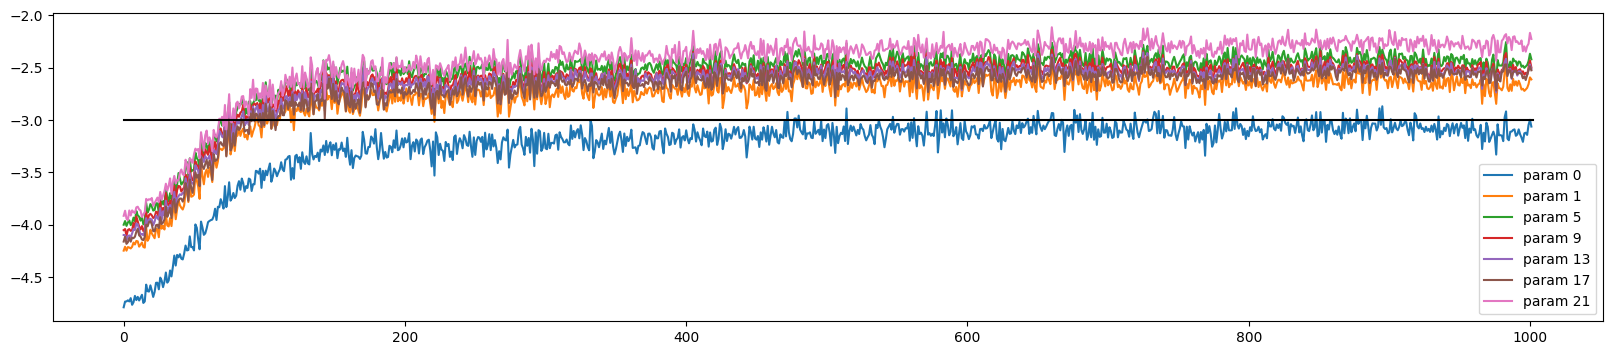

In [134]:
# update:data ratios
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);